In [ ]:
# MODE can be 'TRAIN_FRESH' or 'EVALUATE'
# To do fresh training followed by its evaluation, Set to TRAIN_FRESH
# To only evaluate our pre-trained model, Set to EVALUATE
MODE = 'TRAIN_FRESH'

# This is the model architecture you want to train or test. It can only take the following values.
#'simpleUNET', 'resNETUNET', 'WNET', 'UNETVAE', 'VGG19', 'InceptionV3', 'InceptionResNetV2'
CURRENT_MODEL = 'WNET'


In [ ]:
#!jupyter --version

In [ ]:
!pip install segmentation-models
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 20.5 MB/s eta 0:00:00


In [ ]:
import nilearn
import nibabel as nib
import nilearn.plotting as nlplt

In [ ]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import pandas as pd

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
# Segmentation Models

# Keras
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

Segmentation Models: using `tf.keras` framework.


In [ ]:
# prompt: google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

TRAINING_DATASET = '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/*'

IMAGE_DIR = glob.glob(TRAINING_DATASET)
CSV_LIST = glob.glob(TRAINING_DATASET + 'csv')
for i in CSV_LIST:
    IMAGE_DIR.remove(i)

#IMAGE_DIR.remove(TRAINING_DATASET.replace("*", "") + 'BraTS20_Training_355')
IMAGE_DIR = IMAGE_DIR[103:310]
print(CSV_LIST)

[]


In [ ]:
TRAIN_LIST, VAL_LIST = train_test_split(IMAGE_DIR, test_size=0.2)
TRAIN_LIST, TEST_LIST = train_test_split(TRAIN_LIST, test_size=0.15)

VIEW_IMG_IDX = random.randint(0, len(TRAIN_LIST) - 1)
LIST_DATA = sorted(glob.glob(TRAIN_LIST[VIEW_IMG_IDX] + '/*'))
VIEW_IMAGE = {
    'flair': nib.load(LIST_DATA[0]).get_fdata(),
    't1': nib.load(LIST_DATA[2]).get_fdata(),
    't1ce': nib.load(LIST_DATA[3]).get_fdata(),
    't2': nib.load(LIST_DATA[4]).get_fdata(),
    'mask': nib.load(LIST_DATA[1]).get_fdata()
}

print(f"Train length: {len(TRAIN_LIST)}")
print(f"Validation length: {len(VAL_LIST)}")
print(f"Test length: {len(TEST_LIST)}")

Train length: 140
Validation length: 42
Test length: 25


In [ ]:

MODEL = {
    'simpleUNET': 'simpleUNET.h5',
    'resNETUNET': 'resnetUNET.h5',
    'WNET': 'WNET.h5',
    'UNETVAE': 'UNETVAE.h5',
    'VGG19': 'VGG19.h5',
    'InceptionV3': 'InceptionV3.h5',
    'InceptionResNetV2': 'InceptionResNetV2.h5'
}
LOG = {
    'simpleUNET': 'simpleUNET_training.log',
    'resNETUNET': 'resnetUNET_training.log',
    'WNET': 'WNET_training.log',
    'UNETVAE': 'UNETVAE_training.log',
    'VGG19': 'VGG19_training.log',
    'InceptionV3': 'InceptionV3_training.log',
    'InceptionResNetV2': 'InceptionResnetV2_training.log'
}

SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}
SAVED_MODEL = {
    'WNET': '/content/drive/MyDrive/saved models/WNET.h5',
    'resNETUNET': '../input/resnet-unet-trained-model/resnetUNET.h5',
    'simpleUNET': '../input/simpleunet/simpleUNet.h5',
    'VGG19': '../input/vgg19v2/VGG19.h5',
    'InceptionV3': '../input/inceptionv3/InceptionV3.h5',
    'InceptionResNetV2': '../input/inceptionresnetv2/InceptionResNetV2.h5'
}
SLICES_VOL = 60
VOL_START = 55
IMG_SIZE = 128

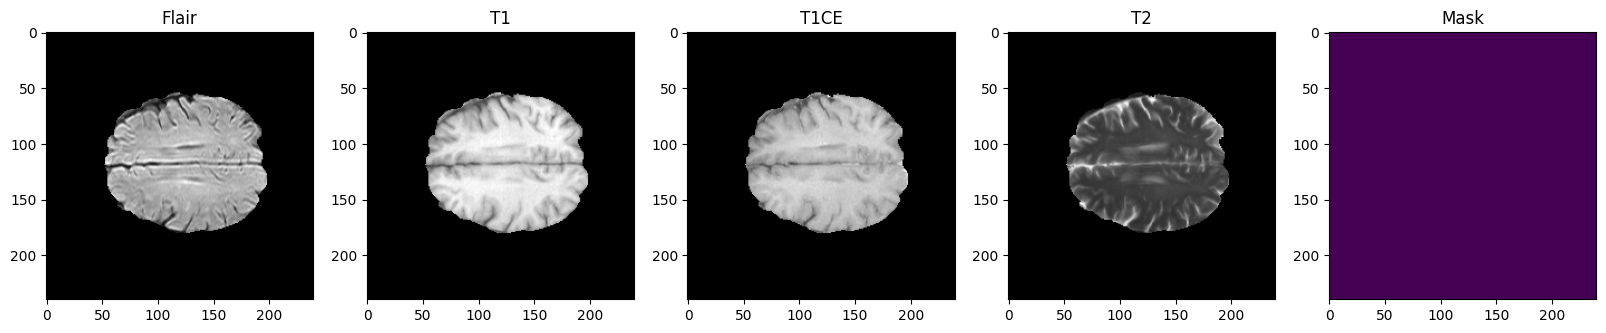

In [ ]:
def analyse_initial_data():
    fig, (axis1, axis2, axis3, axis4, axis5) = plt.subplots(1, 5, figsize=(20, 10))
    slice_w = 25
    axis1.imshow(VIEW_IMAGE['flair'][:, :,
               VIEW_IMAGE['flair'].shape[0]//2 - slice_w], cmap='gray')
    axis1.set_title('Flair')
    axis2.imshow(
        VIEW_IMAGE['t1'][:, :, VIEW_IMAGE['t1'].shape[0]//2 - slice_w], cmap='gray')
    axis2.set_title('T1')
    axis3.imshow(
        VIEW_IMAGE['t1ce'][:, :, VIEW_IMAGE['t1ce'].shape[0]//2 - slice_w], cmap='gray')
    axis3.set_title('T1CE')
    axis4.imshow(
        VIEW_IMAGE['t2'][:, :, VIEW_IMAGE['t2'].shape[0]//2 - slice_w], cmap='gray')
    axis4.set_title('T2')
    axis5.imshow(VIEW_IMAGE['mask']
               [:, :, VIEW_IMAGE['mask'].shape[0]//2 - slice_w])
    axis5.set_title('Mask')


analyse_initial_data()

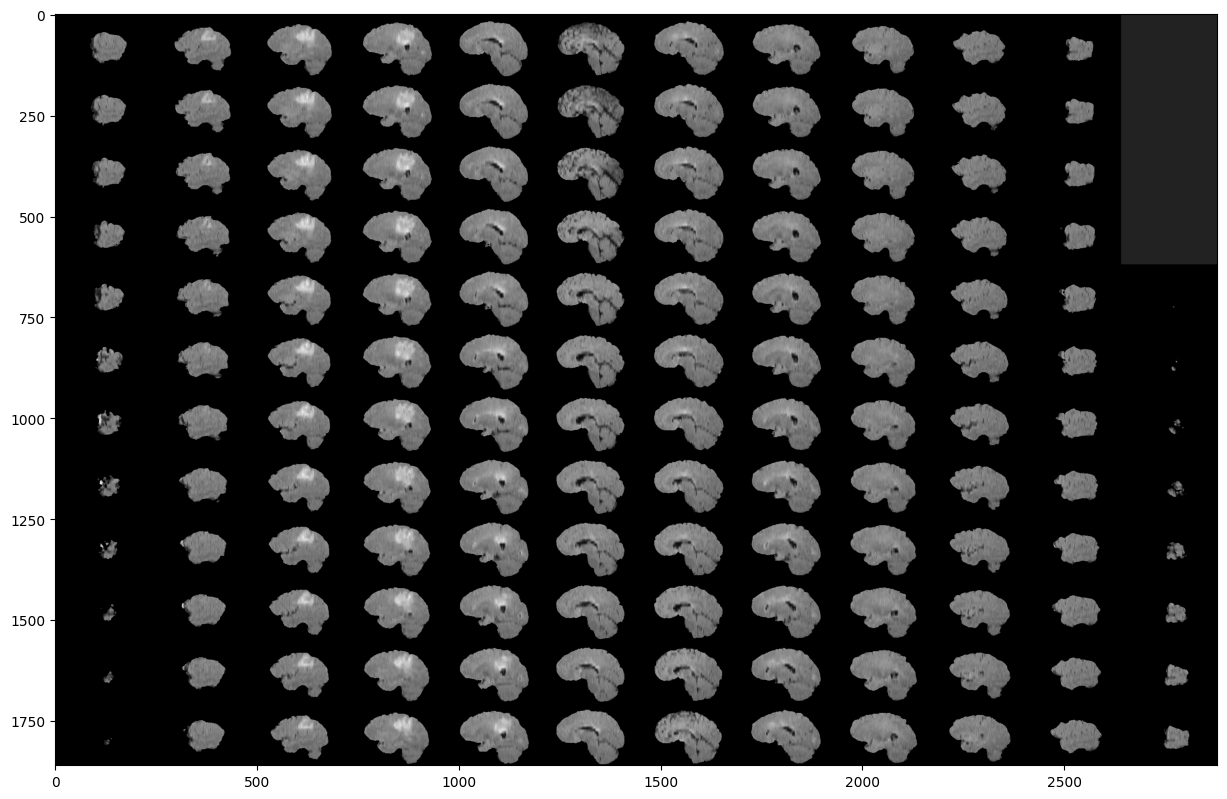

In [ ]:
def show_montage():
    fig, axis = plt.subplots(1, 1, figsize=(15, 15))
    axis.imshow(rotate(
        montage(VIEW_IMAGE['flair'][50:-50, :, :]), 90, resize=True), cmap='gray')


show_montage()

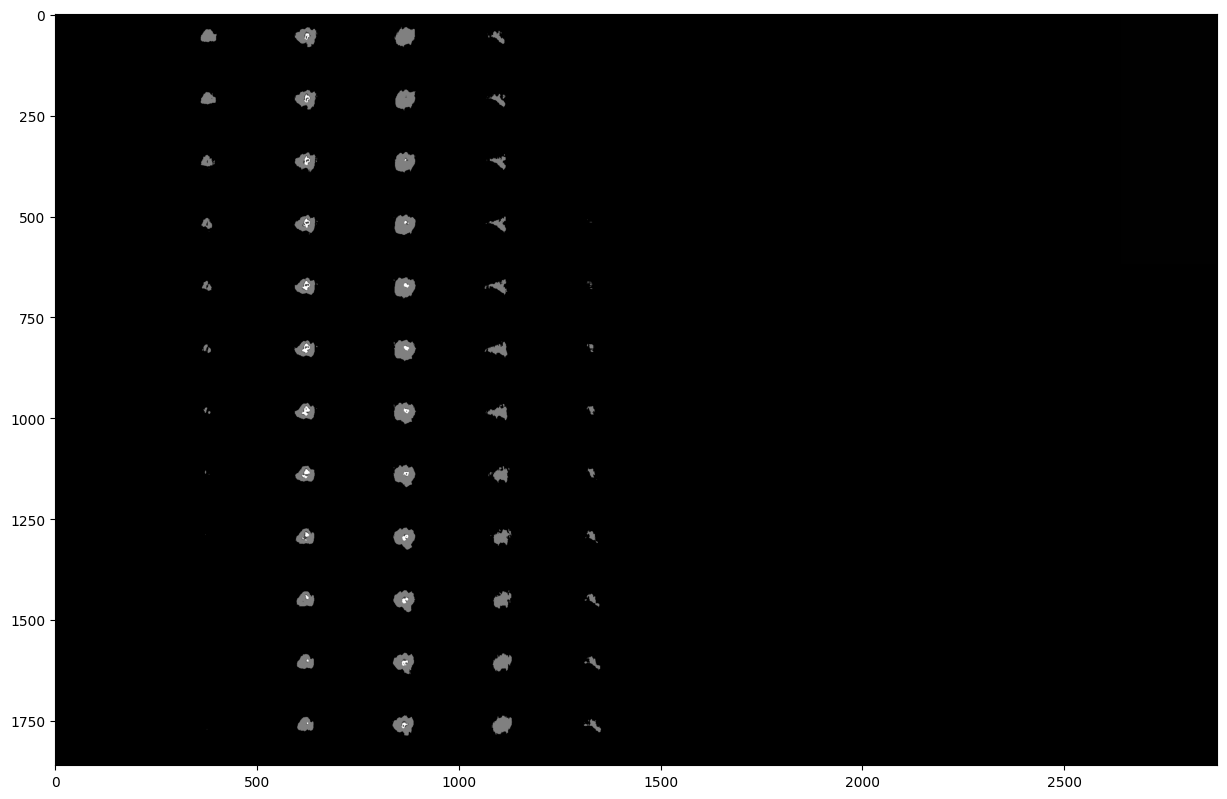

In [ ]:
def show_montage():
    fig, axis = plt.subplots(1, 1, figsize=(15, 15))
    axis.imshow(rotate(
        montage(VIEW_IMAGE['mask'][50:-50, :, :]), 90, resize=True), cmap='gray')


show_montage()

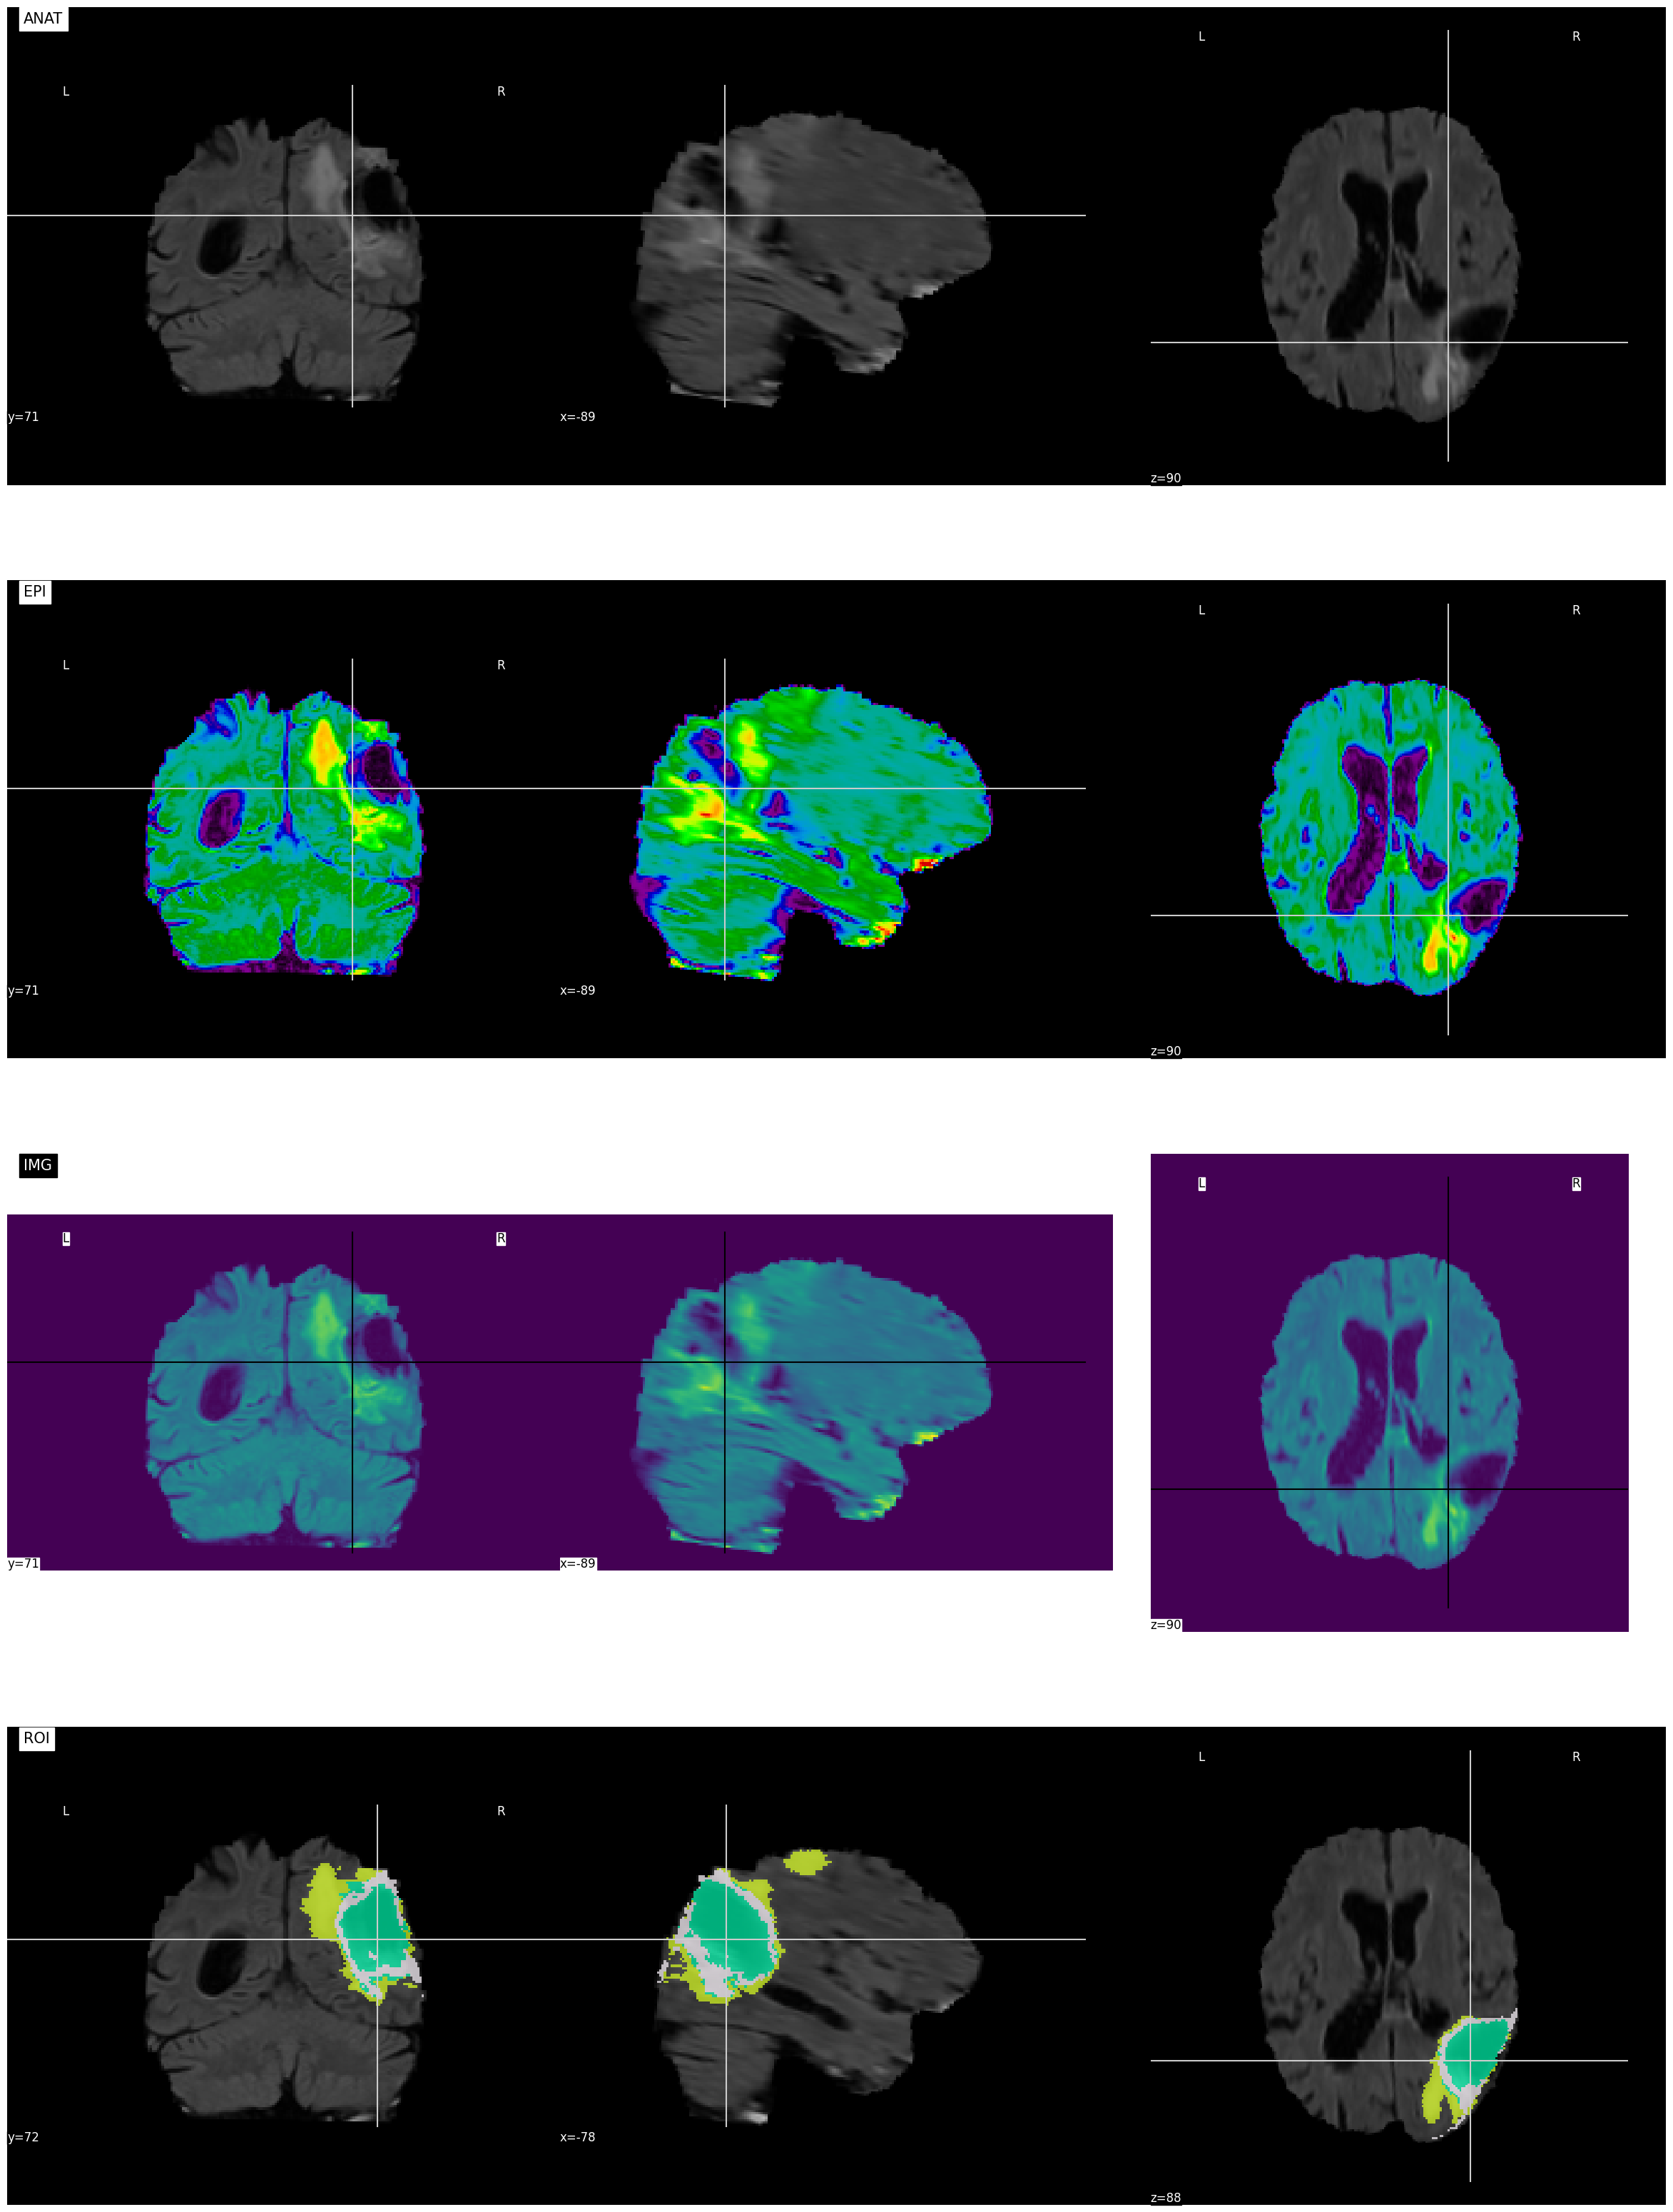

In [ ]:
def show_mri_diagram():
    image = nilearn.image.load_img(LIST_DATA[0])
    mask = nilearn.image.load_img(LIST_DATA[1])
    fig, axes = plt.subplots(nrows=4, figsize=(30, 40))
    nlplt.plot_anat(image, title='ANAT', axes=axes[0])
    nlplt.plot_epi(image, title='EPI', axes=axes[1])
    nlplt.plot_img(image, title='IMG', axes=axes[2])
    nlplt.plot_roi(mask, title='ROI', bg_img=image, axes=axes[3])
    plt.show()


show_mri_diagram()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dimensions=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dimensions = dimensions
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*SLICES_VOL,
                     *self.dimensions, self.n_channels))
        y = np.zeros((self.batch_size*SLICES_VOL, 240, 240))
        Y = np.zeros((self.batch_size*SLICES_VOL, *self.dimensions, 4))
        for c, i in enumerate(Batch_ids):
            base_path = i
            data = base_path.split(os.path.sep)[-1]
            data_path = f'{i}/{data}_flair.nii'
            flair = nib.load(data_path).get_fdata()
            flair = scaler.fit_transform(
                flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

            base_path = i
            data = base_path.split(os.path.sep)[-1]
            data_path = f'{i}/{data}_t1ce.nii'
            ce = nib.load(data_path).get_fdata()
            ce = scaler.fit_transform(
                ce.reshape(-1, ce.shape[-1])).reshape(ce.shape)

            base_path = i
            data = base_path.split(os.path.sep)[-1]
            data_path = f'{i}/{data}_t2.nii'
            t2 = nib.load(data_path).get_fdata()
            t2 = scaler.fit_transform(
                t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)

            base_path = i
            data = base_path.split(os.path.sep)[-1]
            data_path = f'{i}/{data}_seg.nii'
            seg = nib.load(data_path).get_fdata()

            for j in range(SLICES_VOL):
                X[j + SLICES_VOL*c, :, :,
                    0] = cv2.resize(flair[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                X[j + SLICES_VOL*c, :, :,
                    1] = cv2.resize(ce[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                X[j + SLICES_VOL*c, :, :,
                    1] = cv2.resize(t2[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                y[j + SLICES_VOL*c] = seg[:, :, j+VOL_START]

        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y


training_generator = DataGenerator(TRAIN_LIST)
val_generator = DataGenerator(VAL_LIST)
test_generator = DataGenerator(TEST_LIST)

In [ ]:
def resnet_unet():
    BACKBONE = 'resnet50'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 1), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [ ]:
def inceptionresnetv2_unet():
    BACKBONE = 'inceptionresnetv2'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [ ]:
def wnet_architecture():
    """

    Returns:

    """

    inputs = Input(shape=(128, 128, 3), name='input')
    # ------------------------------------------------------

    # Encoder Cycle 1

    # ------------------------------------------------------

    cycle_0_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(inputs)
    cycle_0_normaliaztion1 = BatchNormalization()(cycle_0_convolution1)
    # ------------------------------------------------------
    cycle_0_convolution2 = Conv2D(
        32, 3, padding='same', activation='relu')(cycle_0_normaliaztion1)
    cycle_0_normalization2 = BatchNormalization()(cycle_0_convolution2)
    # ------------------------------------------------------
    cycle_0_pool = MaxPooling2D()(cycle_0_normalization2)
    # ------------------------------------------------------
    cycle_1_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(cycle_0_pool)
    cycle_1_normaliaztion1 = BatchNormalization()(cycle_1_convolution1)
    # ------------------------------------------------------
    cycle_1_convolution2 = Conv2D(
        64, 3, padding='same', activation='relu')(cycle_1_normaliaztion1)
    cycle_1_normalization2 = BatchNormalization()(cycle_1_convolution2)
    # ------------------------------------------------------
    cycle_1_pool = MaxPooling2D()(cycle_1_normalization2)
    # ------------------------------------------------------
    cycle_2_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(cycle_1_pool)
    cycle_2_normaliaztion1 = BatchNormalization()(cycle_2_convolution1)
    # ------------------------------------------------------
    cycle_2_convolution2 = Conv2D(
        128, 3, padding='same', activation='relu')(cycle_2_normaliaztion1)
    cycle_2_normalization2 = BatchNormalization()(cycle_2_convolution2)
    # ------------------------------------------------------
    cycle_2_pool = MaxPooling2D()(cycle_2_normalization2)
    encoder_dropout_1 = Dropout(0.2)(cycle_2_pool)
    # ------------------------------------------------------
    cycle_3_convolution1 = Conv2D(256, 3, padding='same', activation='relu',
                                  )(encoder_dropout_1)
    cycle_3_normaliaztion1 = BatchNormalization()(cycle_3_convolution1)
    # ------------------------------------------------------
    cycle_3_convolution2 = Conv2D(256, 3, padding='same',
                                  activation='relu')(cycle_3_normaliaztion1)
    cycle_3_normalization2 = BatchNormalization()(cycle_3_convolution2)
    # ------------------------------------------------------
    cycle_3_pool = MaxPooling2D()(cycle_3_normalization2)
    # ------------------------------------------------------
    cycle_4_convolution1 = Conv2D(512, 3, padding='same', activation='relu')(cycle_3_pool)
    cycle_4_normaliaztion1 = BatchNormalization()(cycle_4_convolution1)
    # ------------------------------------------------------
    cycle_4_convolution2 = Conv2D(512, 3, padding='same',
                                  activation='relu')(cycle_4_normaliaztion1)
    cycle_4_normalization2 = BatchNormalization()(cycle_4_convolution2)
    # ------------------------------------------------------
    cycle_4_pool = MaxPooling2D()(cycle_4_normalization2)
    # ------------------------------------------------------
    cycle_5_convolution1 = Conv2D(
        1024, 3, padding='same', activation='relu')(cycle_4_pool)
    # ------------------------------------------------------

    # Decoder Cycle 1

    # ------------------------------------------------------
    upscaling_1 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(cycle_5_convolution1)
    merged_cycle_1 = Add()(
        [cycle_4_normaliaztion1, cycle_4_normalization2, upscaling_1])
    decode_cycle_1_convolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged_cycle_1)
    # ------------------------------------------------------
    upscaling_2 = Conv2DTranspose(256, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_1_convolution1)
    merged_cycle_2 = Add()(
        [cycle_3_normaliaztion1, cycle_3_normalization2, upscaling_2])
    decode_cycle_2_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(merged_cycle_2)
    # ------------------------------------------------------
    decoder_dropout_1 = Dropout(
        0.2)(decode_cycle_2_convolution1)
    # ------------------------------------------------------
    upscaling_3 = Conv2DTranspose(128, 3, strides=(
        2, 2), padding='same', activation='relu')(decoder_dropout_1)
    merged_cycle_3 = Add()(
        [cycle_2_normaliaztion1, cycle_2_normalization2, upscaling_3])
    decode_cycle_3_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(merged_cycle_3)
    # ------------------------------------------------------
    upscaling_4 = Conv2DTranspose(64, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_3_convolution1)
    merged_cycle_4 = Add()(
        [cycle_1_normaliaztion1, cycle_1_normaliaztion1, upscaling_4])
    decode_cycle_4_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(merged_cycle_4)
    # ------------------------------------------------------
    upscaling_5 = Conv2DTranspose(32, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_4_convolution1)
    merged_cycle_5 = Add()(
        [cycle_0_normaliaztion1, cycle_0_normalization2, upscaling_5])
    decode_cycle_5_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(merged_cycle_5)
    # ------------------------------------------------------

    # Encoder Cycle 2

    # ------------------------------------------------------
    cycle_6_convolution1 = Conv2D(32, 3, padding='same', activation='relu',
                                  )(decode_cycle_5_convolution1)
    cycle_6_normaliaztion1 = BatchNormalization()(cycle_6_convolution1)
    # ------------------------------------------------------
    cycle_6_convolution2 = Conv2D(32, 3, padding='same',
                                  activation='relu')(cycle_6_normaliaztion1)
    cycle_6_normalization2 = BatchNormalization()(cycle_6_convolution2)
    # ------------------------------------------------------
    cycle_6_pool = MaxPooling2D()(cycle_6_normalization2)
    # ------------------------------------------------------
    cycle_7_convolution1 = Conv2D(64, 3, padding='same',
                                  activation='relu')(cycle_6_pool)
    cycle_7_normaliaztion1 = BatchNormalization()(cycle_7_convolution1)
    # ------------------------------------------------------
    cycle_7_convolution2 = Conv2D(64, 3, padding='same',
                                  activation='relu')(cycle_7_normaliaztion1)
    cycle_7_normalization2 = BatchNormalization()(cycle_7_convolution2)
    # ------------------------------------------------------
    cycle_7_pool = MaxPooling2D()(cycle_7_normalization2)
    # ------------------------------------------------------
    cycle_8_convolution1 = Conv2D(128, 3, padding='same',
                                  activation='relu')(cycle_7_pool)
    cycle_8_normaliaztion1 = BatchNormalization()(cycle_8_convolution1)
    # ------------------------------------------------------
    cycle_8_convolution2 = Conv2D(128, 3, padding='same',
                                  activation='relu')(cycle_8_normaliaztion1)
    cycle_8_normalization2 = BatchNormalization()(cycle_8_convolution2)
    # ------------------------------------------------------
    cycle_8_pool = MaxPooling2D()(cycle_8_normalization2)
    # ------------------------------------------------------
    encoder_dropout_2 = Dropout(0.2)(cycle_8_pool)
    # ------------------------------------------------------
    cycle_9_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(encoder_dropout_2)
    cycle_9_normaliaztion1 = BatchNormalization()(cycle_9_convolution1)
    # ------------------------------------------------------
    cycle_9_convolution2 = Conv2D(256, 3, padding='same',
                                  activation='relu')(cycle_9_normaliaztion1)
    cycle_9_normalization2 = BatchNormalization()(cycle_9_convolution2)
    # ------------------------------------------------------
    cycle_9_pool = MaxPooling2D()(cycle_9_normalization2)
    # ------------------------------------------------------
    cycle_10_convolution1 = Conv2D(512, 3, padding='same',
                                   activation='relu')(cycle_9_pool)
    cycle_10_normaliaztion1 = BatchNormalization()(cycle_10_convolution1)
    # ------------------------------------------------------
    cycle_10_convolution2 = Conv2D(
        512, 3, padding='same', activation='relu')(cycle_10_normaliaztion1)
    cycle_10_normalization2 = BatchNormalization()(cycle_10_convolution2)
    # ------------------------------------------------------
    cycle_10_pool = MaxPooling2D()(cycle_10_normalization2)
    # ------------------------------------------------------
    cycle_11_convolution1 = Conv2D(1024, 3, padding='same',
                                   activation='relu')(cycle_10_pool)
    # ------------------------------------------------------

    # Decoder Cycle 2

    # ------------------------------------------------------

    upscaling_6 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(cycle_11_convolution1)
    merged_cycle_6 = Add()(
        [cycle_10_normaliaztion1, cycle_10_normalization2, upscaling_6])
    decode_cycle_6_convolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged_cycle_6)
    # ------------------------------------------------------
    upscaling_7 = Conv2DTranspose(256, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_6_convolution1)
    merged_cycle_7 = Add()(
        [cycle_9_normaliaztion1, cycle_9_normalization2, upscaling_7])
    decode_cycle_7_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(merged_cycle_7)
    # ------------------------------------------------------
    decoder_dropout_2 = Dropout(
        0.2)(decode_cycle_7_convolution1)
    # ------------------------------------------------------
    upscaling_8 = Conv2DTranspose(128, 3, strides=(
        2, 2), padding='same', activation='relu')(decoder_dropout_2)
    merged_cycle_8 = Add()(
        [cycle_8_normaliaztion1, cycle_8_normalization2, upscaling_8])
    decode_cycle_8_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(merged_cycle_8)
    # ------------------------------------------------------
    upscaling_9 = Conv2DTranspose(64, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_8_convolution1)
    merged_cycle_9 = Add()(
        [cycle_7_normaliaztion1, cycle_7_normaliaztion1, upscaling_9])
    decode_cycle_9_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(merged_cycle_9)
    # ------------------------------------------------------
    upscaling_10 = Conv2DTranspose(32, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_9_convolution1)
    merged_cycle_10 = Add()(
        [cycle_6_normaliaztion1, cycle_6_normalization2, upscaling_10])
    decode_cycle_10_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(merged_cycle_10)
    # ------------------------------------------------------
    pre_output = Conv2D(32, 1, padding='same', activation='relu')(
        decode_cycle_10_convolution1)

    output = Conv2D(4, 1, padding='same', activation='softmax',
                    name='output')(pre_output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [ ]:
from keras.applications import VGG16
from keras.applications import VGG19

In [ ]:
def vgg19_unet():
    BACKBONE = 'vgg19'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


In [ ]:
optim = tf.optimizers.Adam(0.001)
total_loss = sm.losses.categorical_focal_dice_loss
model = None
if CURRENT_MODEL == 'resNETUNET':
    print("RESNETUNET")
    model = resnet_unet()
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity])
elif CURRENT_MODEL == 'WNET':
    print("WNET")
    model = wnet_architecture()
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity,  dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])
elif CURRENT_MODEL == 'InceptionResNetV2':
    print("InceptionResNetV2")
    model = inceptionresnetv2_unet()
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity])
elif CURRENT_MODEL == 'VGG19':
    print("VGG 19")
    model = vgg19_unet()
    adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), sm.metrics.IOUScore(
        threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity]
    )
print(model.summary())

WNET
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['batch_normalization

In [ ]:
#plot_model(model,
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=70)

IndentationError: unexpected indent (<ipython-input-29-448220665a6c>, line 2)

In [ ]:
logger = CSVLogger(LOG[CURRENT_MODEL], separator=',', append=False)
callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                                  patience=2, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=2, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=MODEL[CURRENT_MODEL]),
    logger
]
K.clear_session()

In [ ]:
history = model.fit(training_generator,
                    epochs=20,
                    steps_per_epoch=len(TRAIN_LIST),
                    callbacks=callbacks,
                    validation_data=val_generator,
                    verbose=1
                    )
model.save(MODEL[CURRENT_MODEL])

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node model/conv2d/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-53-c18b3ee610f9>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Detected at node model/conv2d/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-53-c18b3ee610f9>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

2 root error(s) found.
  (0) INVALID_ARGUMENT:  input depth must be evenly divisible by filter depth: 2 vs 3
	 [[{{node model/conv2d/Relu}}]]
	 [[confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/pivot_f/_3/_17]]
  (1) INVALID_ARGUMENT:  input depth must be evenly divisible by filter depth: 2 vs 3
	 [[{{node model/conv2d/Relu}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_55103]

In [ ]:
SAVED_MODEL = {
    'resNETUNET': '/content/resnetUNET.h5',
    'VGG19': '/content/VGG19.h5',
    'WNET': '/content/drive/MyDrive/saved models/WNET.h5',
    'InceptionResNetV2': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionResNetV2/InceptionResNetV2_training.log'
    }

LOG = {
    'resNETUNET': '/content/resnetUNET_training.log',
    'VGG19': '/content/VGG19_training.log',
    'WNET': '/content/drive/MyDrive/saved models/WNET_training.log',
    'InceptionResNetV2': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionResNetV2/InceptionResNetV2_training.log'
    }

model = keras.models.load_model(SAVED_MODEL[CURRENT_MODEL], custom_objects={
                                    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)


model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity])

In [ ]:
history = model.fit(training_generator,
                    epochs=20,
                    steps_per_epoch=len(TRAIN_LIST),
                    callbacks=callbacks,
                    validation_data=val_generator,
                    verbose=1
                    )
model.save(MODEL[CURRENT_MODEL])

Epoch 1/20
136/136 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.9882 - mean_io_u_1: 0.9442 - iou_score: 0.5853 - f1-score: 0.6815 - dice_coef: 0.6806 - precision: 0.9881 - sensitivity: 0.9881 - specificity: 0.9960

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 587s 4s/step - loss: 0.3266 - accuracy: 0.9882 - mean_io_u_1: 0.9442 - iou_score: 0.5853 - f1-score: 0.6815 - dice_coef: 0.6806 - precision: 0.9881 - sensitivity: 0.9881 - specificity: 0.9960 - val_loss: 0.4232 - val_accuracy: 0.9858 - val_mean_io_u_1: 0.9460 - val_iou_score: 0.4938 - val_f1-score: 0.5879 - val_dice_coef: 0.5892 - val_precision: 0.9857 - val_sensitivity: 0.9857 - val_specificity: 0.9952 - lr: 0.0010
Epoch 2/20
136/136 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.9889 - mean_io_u_1: 0.9586 - iou_score: 0.6036 - f1-score: 0.6983 - dice_coef: 0.6976 - precision: 0.9888 - sensitivity: 0.9888 - specificity: 0.9963

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 159s 1s/step - loss: 0.3092 - accuracy: 0.9889 - mean_io_u_1: 0.9586 - iou_score: 0.6036 - f1-score: 0.6983 - dice_coef: 0.6976 - precision: 0.9888 - sensitivity: 0.9888 - specificity: 0.9963 - val_loss: 0.3672 - val_accuracy: 0.9871 - val_mean_io_u_1: 0.9690 - val_iou_score: 0.5463 - val_f1-score: 0.6428 - val_dice_coef: 0.6421 - val_precision: 0.9871 - val_sensitivity: 0.9870 - val_specificity: 0.9957 - lr: 0.0010
Epoch 3/20
136/136 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.9894 - mean_io_u_1: 0.9453 - iou_score: 0.6104 - f1-score: 0.7052 - dice_coef: 0.7044 - precision: 0.9893 - sensitivity: 0.9893 - specificity: 0.9964

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 158s 1s/step - loss: 0.3017 - accuracy: 0.9894 - mean_io_u_1: 0.9453 - iou_score: 0.6104 - f1-score: 0.7052 - dice_coef: 0.7044 - precision: 0.9893 - sensitivity: 0.9893 - specificity: 0.9964 - val_loss: 0.3789 - val_accuracy: 0.9765 - val_mean_io_u_1: 0.9204 - val_iou_score: 0.5363 - val_f1-score: 0.6344 - val_dice_coef: 0.6328 - val_precision: 0.9765 - val_sensitivity: 0.9765 - val_specificity: 0.9922 - lr: 0.0010
Epoch 4/20
136/136 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.9890 - mean_io_u_1: 0.9321 - iou_score: 0.6091 - f1-score: 0.7054 - dice_coef: 0.7035 - precision: 0.9889 - sensitivity: 0.9889 - specificity: 0.9963
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 155s 1s/step - loss: 0.3036 - accuracy: 0.9890 - mean_io_u_1: 0.9321 - iou_score: 0.6091 - f1-score: 0.7054 - dice_coef: 0.7035 - precision: 0.9889 - sensitivity: 0.9889 - specificity: 0.9963 - val_loss: 0.6059 - val_accuracy: 0.9805 - val_mean_io_u_1: 0.9714 - val_iou_score: 0.3668 - val_f1-score: 0.4172 - val_dice_coef: 0.4177 - val_precision: 0.9805 - val_sensitivity: 0.9805 - val_specificity: 0.9935 - lr: 0.0010
Epoch 5/20
136/136 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.9912 - mean_io_u_1: 0.9495 - iou_score: 0.6481 - f1-score: 0.7416 - dice_coef: 0.7414 - precision: 0.9911 - sensitivity: 0.9911 - specificity: 0.9970

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 154s 1s/step - loss: 0.2639 - accuracy: 0.9912 - mean_io_u_1: 0.9495 - iou_score: 0.6481 - f1-score: 0.7416 - dice_coef: 0.7414 - precision: 0.9911 - sensitivity: 0.9911 - specificity: 0.9970 - val_loss: 0.3508 - val_accuracy: 0.9884 - val_mean_io_u_1: 0.9542 - val_iou_score: 0.5631 - val_f1-score: 0.6574 - val_dice_coef: 0.6576 - val_precision: 0.9883 - val_sensitivity: 0.9883 - val_specificity: 0.9961 - lr: 2.0000e-04
Epoch 6/20
136/136 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.9917 - mean_io_u_1: 0.9413 - iou_score: 0.6629 - f1-score: 0.7555 - dice_coef: 0.7552 - precision: 0.9916 - sensitivity: 0.9916 - specificity: 0.9972

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 158s 1s/step - loss: 0.2496 - accuracy: 0.9917 - mean_io_u_1: 0.9413 - iou_score: 0.6629 - f1-score: 0.7555 - dice_coef: 0.7552 - precision: 0.9916 - sensitivity: 0.9916 - specificity: 0.9972 - val_loss: 0.3221 - val_accuracy: 0.9892 - val_mean_io_u_1: 0.9541 - val_iou_score: 0.5935 - val_f1-score: 0.6857 - val_dice_coef: 0.6857 - val_precision: 0.9891 - val_sensitivity: 0.9891 - val_specificity: 0.9964 - lr: 2.0000e-04
Epoch 7/20
136/136 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9919 - mean_io_u_1: 0.9422 - iou_score: 0.6699 - f1-score: 0.7619 - dice_coef: 0.7607 - precision: 0.9918 - sensitivity: 0.9918 - specificity: 0.9973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 155s 1s/step - loss: 0.2451 - accuracy: 0.9919 - mean_io_u_1: 0.9422 - iou_score: 0.6699 - f1-score: 0.7619 - dice_coef: 0.7607 - precision: 0.9918 - sensitivity: 0.9918 - specificity: 0.9973 - val_loss: 0.3154 - val_accuracy: 0.9894 - val_mean_io_u_1: 0.9538 - val_iou_score: 0.5992 - val_f1-score: 0.6916 - val_dice_coef: 0.6917 - val_precision: 0.9893 - val_sensitivity: 0.9893 - val_specificity: 0.9964 - lr: 2.0000e-04
Epoch 8/20
136/136 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9921 - mean_io_u_1: 0.9428 - iou_score: 0.6751 - f1-score: 0.7666 - dice_coef: 0.7659 - precision: 0.9920 - sensitivity: 0.9920 - specificity: 0.9973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 163s 1s/step - loss: 0.2403 - accuracy: 0.9921 - mean_io_u_1: 0.9428 - iou_score: 0.6751 - f1-score: 0.7666 - dice_coef: 0.7659 - precision: 0.9920 - sensitivity: 0.9920 - specificity: 0.9973 - val_loss: 0.3054 - val_accuracy: 0.9895 - val_mean_io_u_1: 0.9252 - val_iou_score: 0.6067 - val_f1-score: 0.7017 - val_dice_coef: 0.7013 - val_precision: 0.9894 - val_sensitivity: 0.9894 - val_specificity: 0.9965 - lr: 2.0000e-04
Epoch 9/20
136/136 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9922 - mean_io_u_1: 0.9444 - iou_score: 0.6800 - f1-score: 0.7715 - dice_coef: 0.7697 - precision: 0.9921 - sensitivity: 0.9920 - specificity: 0.9974

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 153s 1s/step - loss: 0.2372 - accuracy: 0.9922 - mean_io_u_1: 0.9444 - iou_score: 0.6800 - f1-score: 0.7715 - dice_coef: 0.7697 - precision: 0.9921 - sensitivity: 0.9920 - specificity: 0.9974 - val_loss: 0.3164 - val_accuracy: 0.9893 - val_mean_io_u_1: 0.9667 - val_iou_score: 0.5980 - val_f1-score: 0.6912 - val_dice_coef: 0.6912 - val_precision: 0.9892 - val_sensitivity: 0.9893 - val_specificity: 0.9964 - lr: 2.0000e-04
Epoch 10/20
136/136 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9924 - mean_io_u_1: 0.9436 - iou_score: 0.6847 - f1-score: 0.7755 - dice_coef: 0.7742 - precision: 0.9923 - sensitivity: 0.9923 - specificity: 0.9974
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 159s 1s/step - loss: 0.2329 - accuracy: 0.9924 - mean_io_u_1: 0.9436 - iou_score: 0.6847 - f1-score: 0.7755 - dice_coef: 0.7742 - precision: 0.9923 - sensitivity: 0.9923 - specificity: 0.9974 - val_loss: 0.3056 - val_accuracy: 0.9898 - val_mean_io_u_1: 0.9575 - val_iou_score: 0.6083 - val_f1-score: 0.7013 - val_dice_coef: 0.7022 - val_precision: 0.9897 - val_sensitivity: 0.9897 - val_specificity: 0.9966 - lr: 2.0000e-04
Epoch 11/20
136/136 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9927 - mean_io_u_1: 0.9438 - iou_score: 0.6937 - f1-score: 0.7836 - dice_coef: 0.7821 - precision: 0.9925 - sensitivity: 0.9925 - specificity: 0.9975

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 153s 1s/step - loss: 0.2248 - accuracy: 0.9927 - mean_io_u_1: 0.9438 - iou_score: 0.6937 - f1-score: 0.7836 - dice_coef: 0.7821 - precision: 0.9925 - sensitivity: 0.9925 - specificity: 0.9975 - val_loss: 0.3016 - val_accuracy: 0.9898 - val_mean_io_u_1: 0.9478 - val_iou_score: 0.6125 - val_f1-score: 0.7050 - val_dice_coef: 0.7052 - val_precision: 0.9897 - val_sensitivity: 0.9897 - val_specificity: 0.9966 - lr: 4.0000e-05
Epoch 12/20
136/136 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9928 - mean_io_u_1: 0.9409 - iou_score: 0.6927 - f1-score: 0.7824 - dice_coef: 0.7830 - precision: 0.9926 - sensitivity: 0.9926 - specificity: 0.9975

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 150s 1s/step - loss: 0.2222 - accuracy: 0.9928 - mean_io_u_1: 0.9409 - iou_score: 0.6927 - f1-score: 0.7824 - dice_coef: 0.7830 - precision: 0.9926 - sensitivity: 0.9926 - specificity: 0.9975 - val_loss: 0.2995 - val_accuracy: 0.9899 - val_mean_io_u_1: 0.9491 - val_iou_score: 0.6134 - val_f1-score: 0.7071 - val_dice_coef: 0.7073 - val_precision: 0.9898 - val_sensitivity: 0.9898 - val_specificity: 0.9966 - lr: 4.0000e-05
Epoch 13/20
136/136 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9928 - mean_io_u_1: 0.9403 - iou_score: 0.6981 - f1-score: 0.7876 - dice_coef: 0.7865 - precision: 0.9927 - sensitivity: 0.9927 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 148s 1s/step - loss: 0.2207 - accuracy: 0.9928 - mean_io_u_1: 0.9403 - iou_score: 0.6981 - f1-score: 0.7876 - dice_coef: 0.7865 - precision: 0.9927 - sensitivity: 0.9927 - specificity: 0.9976 - val_loss: 0.2946 - val_accuracy: 0.9901 - val_mean_io_u_1: 0.9466 - val_iou_score: 0.6189 - val_f1-score: 0.7119 - val_dice_coef: 0.7119 - val_precision: 0.9900 - val_sensitivity: 0.9900 - val_specificity: 0.9967 - lr: 4.0000e-05
Epoch 14/20
136/136 [==============================] - ETA: 0s - loss: 0.2195 - accuracy: 0.9929 - mean_io_u_1: 0.9430 - iou_score: 0.6975 - f1-score: 0.7871 - dice_coef: 0.7863 - precision: 0.9928 - sensitivity: 0.9927 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 153s 1s/step - loss: 0.2195 - accuracy: 0.9929 - mean_io_u_1: 0.9430 - iou_score: 0.6975 - f1-score: 0.7871 - dice_coef: 0.7863 - precision: 0.9928 - sensitivity: 0.9927 - specificity: 0.9976 - val_loss: 0.2976 - val_accuracy: 0.9899 - val_mean_io_u_1: 0.9475 - val_iou_score: 0.6158 - val_f1-score: 0.7090 - val_dice_coef: 0.7096 - val_precision: 0.9898 - val_sensitivity: 0.9898 - val_specificity: 0.9966 - lr: 4.0000e-05
Epoch 15/20
136/136 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9929 - mean_io_u_1: 0.9415 - iou_score: 0.7009 - f1-score: 0.7902 - dice_coef: 0.7892 - precision: 0.9928 - sensitivity: 0.9928 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 152s 1s/step - loss: 0.2180 - accuracy: 0.9929 - mean_io_u_1: 0.9415 - iou_score: 0.7009 - f1-score: 0.7902 - dice_coef: 0.7892 - precision: 0.9928 - sensitivity: 0.9928 - specificity: 0.9976 - val_loss: 0.2941 - val_accuracy: 0.9901 - val_mean_io_u_1: 0.9473 - val_iou_score: 0.6204 - val_f1-score: 0.7123 - val_dice_coef: 0.7126 - val_precision: 0.9900 - val_sensitivity: 0.9900 - val_specificity: 0.9967 - lr: 4.0000e-05
Epoch 16/20
136/136 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9929 - mean_io_u_1: 0.9411 - iou_score: 0.7017 - f1-score: 0.7911 - dice_coef: 0.7901 - precision: 0.9928 - sensitivity: 0.9928 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 151s 1s/step - loss: 0.2173 - accuracy: 0.9929 - mean_io_u_1: 0.9411 - iou_score: 0.7017 - f1-score: 0.7911 - dice_coef: 0.7901 - precision: 0.9928 - sensitivity: 0.9928 - specificity: 0.9976 - val_loss: 0.2940 - val_accuracy: 0.9901 - val_mean_io_u_1: 0.9509 - val_iou_score: 0.6189 - val_f1-score: 0.7125 - val_dice_coef: 0.7130 - val_precision: 0.9900 - val_sensitivity: 0.9900 - val_specificity: 0.9967 - lr: 4.0000e-05
Epoch 17/20
136/136 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9930 - mean_io_u_1: 0.9418 - iou_score: 0.7032 - f1-score: 0.7925 - dice_coef: 0.7913 - precision: 0.9928 - sensitivity: 0.9928 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 160s 1s/step - loss: 0.2158 - accuracy: 0.9930 - mean_io_u_1: 0.9418 - iou_score: 0.7032 - f1-score: 0.7925 - dice_coef: 0.7913 - precision: 0.9928 - sensitivity: 0.9928 - specificity: 0.9976 - val_loss: 0.2949 - val_accuracy: 0.9899 - val_mean_io_u_1: 0.9518 - val_iou_score: 0.6185 - val_f1-score: 0.7116 - val_dice_coef: 0.7123 - val_precision: 0.9899 - val_sensitivity: 0.9899 - val_specificity: 0.9966 - lr: 4.0000e-05
Epoch 18/20
136/136 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9930 - mean_io_u_1: 0.9436 - iou_score: 0.7045 - f1-score: 0.7936 - dice_coef: 0.7921 - precision: 0.9929 - sensitivity: 0.9929 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 147s 1s/step - loss: 0.2148 - accuracy: 0.9930 - mean_io_u_1: 0.9436 - iou_score: 0.7045 - f1-score: 0.7936 - dice_coef: 0.7921 - precision: 0.9929 - sensitivity: 0.9929 - specificity: 0.9976 - val_loss: 0.2883 - val_accuracy: 0.9902 - val_mean_io_u_1: 0.9483 - val_iou_score: 0.6241 - val_f1-score: 0.7182 - val_dice_coef: 0.7183 - val_precision: 0.9901 - val_sensitivity: 0.9901 - val_specificity: 0.9967 - lr: 4.0000e-05
Epoch 19/20
136/136 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9931 - mean_io_u_1: 0.9440 - iou_score: 0.7056 - f1-score: 0.7946 - dice_coef: 0.7935 - precision: 0.9929 - sensitivity: 0.9929 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 147s 1s/step - loss: 0.2137 - accuracy: 0.9931 - mean_io_u_1: 0.9440 - iou_score: 0.7056 - f1-score: 0.7946 - dice_coef: 0.7935 - precision: 0.9929 - sensitivity: 0.9929 - specificity: 0.9976 - val_loss: 0.2855 - val_accuracy: 0.9904 - val_mean_io_u_1: 0.9504 - val_iou_score: 0.6274 - val_f1-score: 0.7207 - val_dice_coef: 0.7208 - val_precision: 0.9903 - val_sensitivity: 0.9903 - val_specificity: 0.9968 - lr: 4.0000e-05
Epoch 20/20
136/136 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9931 - mean_io_u_1: 0.9434 - iou_score: 0.7067 - f1-score: 0.7957 - dice_coef: 0.7946 - precision: 0.9929 - sensitivity: 0.9929 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 150s 1s/step - loss: 0.2126 - accuracy: 0.9931 - mean_io_u_1: 0.9434 - iou_score: 0.7067 - f1-score: 0.7957 - dice_coef: 0.7946 - precision: 0.9929 - sensitivity: 0.9929 - specificity: 0.9976 - val_loss: 0.2870 - val_accuracy: 0.9905 - val_mean_io_u_1: 0.9522 - val_iou_score: 0.6262 - val_f1-score: 0.7191 - val_dice_coef: 0.7195 - val_precision: 0.9904 - val_sensitivity: 0.9904 - val_specificity: 0.9968 - lr: 4.0000e-05


In [ ]:
SAVED_MODEL = {
    'resNETUNET': '/content/resnetUNET.h5',
    'VGG19': '/content/VGG19.h5',
    'WNET': '/content/WNET.h5',
    'InceptionResNetV2': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionResNetV2/InceptionResNetV2_training.log'
    }

LOG = {
    'resNETUNET': '/content/resnetUNET_training.log',
    'VGG19': '/content/VGG19_training.log',
    'WNET': '/content/WNET_training.log',
    'InceptionResNetV2': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionResNetV2/InceptionResNetV2_training.log'
    }

model = keras.models.load_model(SAVED_MODEL[CURRENT_MODEL], custom_objects={
                                    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)


model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity])

In [ ]:
history = model.fit(training_generator,
                    epochs=20,
                    steps_per_epoch=len(TRAIN_LIST),
                    callbacks=callbacks,
                    validation_data=val_generator,
                    verbose=1
                    )
model.save(MODEL[CURRENT_MODEL])

Epoch 1/20
136/136 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.9899 - mean_io_u_4: 0.9423 - iou_score: 0.6266 - f1-score: 0.7226 - dice_coef: 0.7221 - precision: 0.9898 - sensitivity: 0.9898 - specificity: 0.9966

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 199s 1s/step - loss: 0.2842 - accuracy: 0.9899 - mean_io_u_4: 0.9423 - iou_score: 0.6266 - f1-score: 0.7226 - dice_coef: 0.7221 - precision: 0.9898 - sensitivity: 0.9898 - specificity: 0.9966 - val_loss: 0.4402 - val_accuracy: 0.9849 - val_mean_io_u_4: 0.9708 - val_iou_score: 0.4928 - val_f1-score: 0.5714 - val_dice_coef: 0.5747 - val_precision: 0.9848 - val_sensitivity: 0.9849 - val_specificity: 0.9949 - lr: 0.0010
Epoch 2/20
136/136 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.9904 - mean_io_u_4: 0.9233 - iou_score: 0.6387 - f1-score: 0.7336 - dice_coef: 0.7330 - precision: 0.9903 - sensitivity: 0.9903 - specificity: 0.9968

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 153s 1s/step - loss: 0.2726 - accuracy: 0.9904 - mean_io_u_4: 0.9233 - iou_score: 0.6387 - f1-score: 0.7336 - dice_coef: 0.7330 - precision: 0.9903 - sensitivity: 0.9903 - specificity: 0.9968 - val_loss: 0.4440 - val_accuracy: 0.9821 - val_mean_io_u_4: 0.9601 - val_iou_score: 0.4911 - val_f1-score: 0.5715 - val_dice_coef: 0.5723 - val_precision: 0.9821 - val_sensitivity: 0.9821 - val_specificity: 0.9940 - lr: 0.0010
Epoch 3/20
136/136 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.9901 - mean_io_u_4: 0.9458 - iou_score: 0.6394 - f1-score: 0.7359 - dice_coef: 0.7355 - precision: 0.9900 - sensitivity: 0.9900 - specificity: 0.9967
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 150s 1s/step - loss: 0.2705 - accuracy: 0.9901 - mean_io_u_4: 0.9458 - iou_score: 0.6394 - f1-score: 0.7359 - dice_coef: 0.7355 - precision: 0.9900 - sensitivity: 0.9900 - specificity: 0.9967 - val_loss: 0.5258 - val_accuracy: 0.9793 - val_mean_io_u_4: 0.9649 - val_iou_score: 0.4276 - val_f1-score: 0.4930 - val_dice_coef: 0.4955 - val_precision: 0.9793 - val_sensitivity: 0.9793 - val_specificity: 0.9931 - lr: 0.0010
Epoch 4/20
136/136 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9918 - mean_io_u_4: 0.9544 - iou_score: 0.6728 - f1-score: 0.7658 - dice_coef: 0.7661 - precision: 0.9917 - sensitivity: 0.9917 - specificity: 0.9972

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 162s 1s/step - loss: 0.2393 - accuracy: 0.9918 - mean_io_u_4: 0.9544 - iou_score: 0.6728 - f1-score: 0.7658 - dice_coef: 0.7661 - precision: 0.9917 - sensitivity: 0.9917 - specificity: 0.9972 - val_loss: 0.3822 - val_accuracy: 0.9863 - val_mean_io_u_4: 0.9510 - val_iou_score: 0.5454 - val_f1-score: 0.6281 - val_dice_coef: 0.6301 - val_precision: 0.9862 - val_sensitivity: 0.9862 - val_specificity: 0.9954 - lr: 2.0000e-04
Epoch 5/20
136/136 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9926 - mean_io_u_4: 0.9426 - iou_score: 0.6903 - f1-score: 0.7813 - dice_coef: 0.7820 - precision: 0.9925 - sensitivity: 0.9925 - specificity: 0.9975

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 149s 1s/step - loss: 0.2233 - accuracy: 0.9926 - mean_io_u_4: 0.9426 - iou_score: 0.6903 - f1-score: 0.7813 - dice_coef: 0.7820 - precision: 0.9925 - sensitivity: 0.9925 - specificity: 0.9975 - val_loss: 0.3674 - val_accuracy: 0.9867 - val_mean_io_u_4: 0.9509 - val_iou_score: 0.5576 - val_f1-score: 0.6424 - val_dice_coef: 0.6442 - val_precision: 0.9867 - val_sensitivity: 0.9867 - val_specificity: 0.9956 - lr: 2.0000e-04
Epoch 6/20
136/136 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9928 - mean_io_u_4: 0.9429 - iou_score: 0.6972 - f1-score: 0.7879 - dice_coef: 0.7866 - precision: 0.9926 - sensitivity: 0.9926 - specificity: 0.9975

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 152s 1s/step - loss: 0.2204 - accuracy: 0.9928 - mean_io_u_4: 0.9429 - iou_score: 0.6972 - f1-score: 0.7879 - dice_coef: 0.7866 - precision: 0.9926 - sensitivity: 0.9926 - specificity: 0.9975 - val_loss: 0.3493 - val_accuracy: 0.9875 - val_mean_io_u_4: 0.9554 - val_iou_score: 0.5746 - val_f1-score: 0.6595 - val_dice_coef: 0.6616 - val_precision: 0.9874 - val_sensitivity: 0.9874 - val_specificity: 0.9958 - lr: 2.0000e-04
Epoch 7/20
136/136 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9930 - mean_io_u_4: 0.9391 - iou_score: 0.7053 - f1-score: 0.7952 - dice_coef: 0.7937 - precision: 0.9928 - sensitivity: 0.9928 - specificity: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 153s 1s/step - loss: 0.2148 - accuracy: 0.9930 - mean_io_u_4: 0.9391 - iou_score: 0.7053 - f1-score: 0.7952 - dice_coef: 0.7937 - precision: 0.9928 - sensitivity: 0.9928 - specificity: 0.9976 - val_loss: 0.3526 - val_accuracy: 0.9873 - val_mean_io_u_4: 0.9501 - val_iou_score: 0.5696 - val_f1-score: 0.6564 - val_dice_coef: 0.6588 - val_precision: 0.9872 - val_sensitivity: 0.9872 - val_specificity: 0.9957 - lr: 2.0000e-04
Epoch 8/20
136/136 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.9932 - mean_io_u_4: 0.9405 - iou_score: 0.7079 - f1-score: 0.7974 - dice_coef: 0.7959 - precision: 0.9930 - sensitivity: 0.9930 - specificity: 0.9977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 151s 1s/step - loss: 0.2106 - accuracy: 0.9932 - mean_io_u_4: 0.9405 - iou_score: 0.7079 - f1-score: 0.7974 - dice_coef: 0.7959 - precision: 0.9930 - sensitivity: 0.9930 - specificity: 0.9977 - val_loss: 0.3320 - val_accuracy: 0.9883 - val_mean_io_u_4: 0.9375 - val_iou_score: 0.5866 - val_f1-score: 0.6756 - val_dice_coef: 0.6775 - val_precision: 0.9882 - val_sensitivity: 0.9882 - val_specificity: 0.9961 - lr: 2.0000e-04
Epoch 9/20
136/136 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9933 - mean_io_u_4: 0.9342 - iou_score: 0.7126 - f1-score: 0.8013 - dice_coef: 0.8007 - precision: 0.9932 - sensitivity: 0.9931 - specificity: 0.9977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 154s 1s/step - loss: 0.2067 - accuracy: 0.9933 - mean_io_u_4: 0.9342 - iou_score: 0.7126 - f1-score: 0.8013 - dice_coef: 0.8007 - precision: 0.9932 - sensitivity: 0.9931 - specificity: 0.9977 - val_loss: 0.3343 - val_accuracy: 0.9879 - val_mean_io_u_4: 0.9455 - val_iou_score: 0.5847 - val_f1-score: 0.6734 - val_dice_coef: 0.6755 - val_precision: 0.9878 - val_sensitivity: 0.9878 - val_specificity: 0.9959 - lr: 2.0000e-04
Epoch 10/20
136/136 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9933 - mean_io_u_4: 0.9357 - iou_score: 0.7135 - f1-score: 0.8023 - dice_coef: 0.8013 - precision: 0.9932 - sensitivity: 0.9932 - specificity: 0.9977
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 154s 1s/step - loss: 0.2056 - accuracy: 0.9933 - mean_io_u_4: 0.9357 - iou_score: 0.7135 - f1-score: 0.8023 - dice_coef: 0.8013 - precision: 0.9932 - sensitivity: 0.9932 - specificity: 0.9977 - val_loss: 0.3409 - val_accuracy: 0.9875 - val_mean_io_u_4: 0.9270 - val_iou_score: 0.5796 - val_f1-score: 0.6678 - val_dice_coef: 0.6701 - val_precision: 0.9874 - val_sensitivity: 0.9874 - val_specificity: 0.9958 - lr: 2.0000e-04
Epoch 11/20
136/136 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9937 - mean_io_u_4: 0.9277 - iou_score: 0.7228 - f1-score: 0.8101 - dice_coef: 0.8093 - precision: 0.9935 - sensitivity: 0.9935 - specificity: 0.9978

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 152s 1s/step - loss: 0.1977 - accuracy: 0.9937 - mean_io_u_4: 0.9277 - iou_score: 0.7228 - f1-score: 0.8101 - dice_coef: 0.8093 - precision: 0.9935 - sensitivity: 0.9935 - specificity: 0.9978 - val_loss: 0.3289 - val_accuracy: 0.9882 - val_mean_io_u_4: 0.9385 - val_iou_score: 0.5915 - val_f1-score: 0.6792 - val_dice_coef: 0.6812 - val_precision: 0.9881 - val_sensitivity: 0.9881 - val_specificity: 0.9960 - lr: 4.0000e-05
Epoch 12/20
136/136 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9937 - mean_io_u_4: 0.9314 - iou_score: 0.7258 - f1-score: 0.8126 - dice_coef: 0.8120 - precision: 0.9936 - sensitivity: 0.9936 - specificity: 0.9979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 152s 1s/step - loss: 0.1952 - accuracy: 0.9937 - mean_io_u_4: 0.9314 - iou_score: 0.7258 - f1-score: 0.8126 - dice_coef: 0.8120 - precision: 0.9936 - sensitivity: 0.9936 - specificity: 0.9979 - val_loss: 0.3288 - val_accuracy: 0.9883 - val_mean_io_u_4: 0.9402 - val_iou_score: 0.5908 - val_f1-score: 0.6790 - val_dice_coef: 0.6815 - val_precision: 0.9882 - val_sensitivity: 0.9882 - val_specificity: 0.9961 - lr: 4.0000e-05
Epoch 13/20
136/136 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9938 - mean_io_u_4: 0.9326 - iou_score: 0.7271 - f1-score: 0.8137 - dice_coef: 0.8134 - precision: 0.9936 - sensitivity: 0.9936 - specificity: 0.9979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 168s 1s/step - loss: 0.1941 - accuracy: 0.9938 - mean_io_u_4: 0.9326 - iou_score: 0.7271 - f1-score: 0.8137 - dice_coef: 0.8134 - precision: 0.9936 - sensitivity: 0.9936 - specificity: 0.9979 - val_loss: 0.3324 - val_accuracy: 0.9881 - val_mean_io_u_4: 0.9378 - val_iou_score: 0.5874 - val_f1-score: 0.6756 - val_dice_coef: 0.6782 - val_precision: 0.9880 - val_sensitivity: 0.9880 - val_specificity: 0.9960 - lr: 4.0000e-05
Epoch 14/20
136/136 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9938 - mean_io_u_4: 0.9315 - iou_score: 0.7287 - f1-score: 0.8151 - dice_coef: 0.8145 - precision: 0.9937 - sensitivity: 0.9937 - specificity: 0.9979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 153s 1s/step - loss: 0.1927 - accuracy: 0.9938 - mean_io_u_4: 0.9315 - iou_score: 0.7287 - f1-score: 0.8151 - dice_coef: 0.8145 - precision: 0.9937 - sensitivity: 0.9937 - specificity: 0.9979 - val_loss: 0.3259 - val_accuracy: 0.9884 - val_mean_io_u_4: 0.9370 - val_iou_score: 0.5929 - val_f1-score: 0.6817 - val_dice_coef: 0.6841 - val_precision: 0.9883 - val_sensitivity: 0.9883 - val_specificity: 0.9961 - lr: 4.0000e-05
Epoch 15/20
136/136 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9938 - mean_io_u_4: 0.9328 - iou_score: 0.7294 - f1-score: 0.8158 - dice_coef: 0.8155 - precision: 0.9937 - sensitivity: 0.9937 - specificity: 0.9979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 166s 1s/step - loss: 0.1920 - accuracy: 0.9938 - mean_io_u_4: 0.9328 - iou_score: 0.7294 - f1-score: 0.8158 - dice_coef: 0.8155 - precision: 0.9937 - sensitivity: 0.9937 - specificity: 0.9979 - val_loss: 0.3313 - val_accuracy: 0.9881 - val_mean_io_u_4: 0.9380 - val_iou_score: 0.5892 - val_f1-score: 0.6767 - val_dice_coef: 0.6792 - val_precision: 0.9880 - val_sensitivity: 0.9880 - val_specificity: 0.9960 - lr: 4.0000e-05
Epoch 16/20
136/136 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9939 - mean_io_u_4: 0.9305 - iou_score: 0.7304 - f1-score: 0.8166 - dice_coef: 0.8161 - precision: 0.9937 - sensitivity: 0.9937 - specificity: 0.9979
Epoch 16: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 155s 1s/step - loss: 0.1911 - accuracy: 0.9939 - mean_io_u_4: 0.9305 - iou_score: 0.7304 - f1-score: 0.8166 - dice_coef: 0.8161 - precision: 0.9937 - sensitivity: 0.9937 - specificity: 0.9979 - val_loss: 0.3296 - val_accuracy: 0.9883 - val_mean_io_u_4: 0.9362 - val_iou_score: 0.5896 - val_f1-score: 0.6780 - val_dice_coef: 0.6805 - val_precision: 0.9882 - val_sensitivity: 0.9882 - val_specificity: 0.9961 - lr: 4.0000e-05
Epoch 17/20
136/136 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9939 - mean_io_u_4: 0.9316 - iou_score: 0.7326 - f1-score: 0.8184 - dice_coef: 0.8177 - precision: 0.9938 - sensitivity: 0.9938 - specificity: 0.9979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 157s 1s/step - loss: 0.1894 - accuracy: 0.9939 - mean_io_u_4: 0.9316 - iou_score: 0.7326 - f1-score: 0.8184 - dice_coef: 0.8177 - precision: 0.9938 - sensitivity: 0.9938 - specificity: 0.9979 - val_loss: 0.3278 - val_accuracy: 0.9884 - val_mean_io_u_4: 0.9382 - val_iou_score: 0.5913 - val_f1-score: 0.6797 - val_dice_coef: 0.6823 - val_precision: 0.9883 - val_sensitivity: 0.9883 - val_specificity: 0.9961 - lr: 8.0000e-06
Epoch 18/20
136/136 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9939 - mean_io_u_4: 0.9322 - iou_score: 0.7328 - f1-score: 0.8186 - dice_coef: 0.8181 - precision: 0.9938 - sensitivity: 0.9938 - specificity: 0.9979
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 152s 1s/step - loss: 0.1891 - accuracy: 0.9939 - mean_io_u_4: 0.9322 - iou_score: 0.7328 - f1-score: 0.8186 - dice_coef: 0.8181 - precision: 0.9938 - sensitivity: 0.9938 - specificity: 0.9979 - val_loss: 0.3295 - val_accuracy: 0.9882 - val_mean_io_u_4: 0.9382 - val_iou_score: 0.5903 - val_f1-score: 0.6784 - val_dice_coef: 0.6808 - val_precision: 0.9882 - val_sensitivity: 0.9881 - val_specificity: 0.9960 - lr: 8.0000e-06
Epoch 19/20
136/136 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9940 - mean_io_u_4: 0.9327 - iou_score: 0.7335 - f1-score: 0.8192 - dice_coef: 0.8187 - precision: 0.9938 - sensitivity: 0.9938 - specificity: 0.9979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 161s 1s/step - loss: 0.1885 - accuracy: 0.9940 - mean_io_u_4: 0.9327 - iou_score: 0.7335 - f1-score: 0.8192 - dice_coef: 0.8187 - precision: 0.9938 - sensitivity: 0.9938 - specificity: 0.9979 - val_loss: 0.3286 - val_accuracy: 0.9883 - val_mean_io_u_4: 0.9383 - val_iou_score: 0.5907 - val_f1-score: 0.6790 - val_dice_coef: 0.6816 - val_precision: 0.9882 - val_sensitivity: 0.9882 - val_specificity: 0.9961 - lr: 1.6000e-06
Epoch 20/20
136/136 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9940 - mean_io_u_4: 0.9323 - iou_score: 0.7335 - f1-score: 0.8191 - dice_coef: 0.8187 - precision: 0.9938 - sensitivity: 0.9938 - specificity: 0.9979
Epoch 20: ReduceLROnPlateau reducing learning rate to 1e-06.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 168s 1s/step - loss: 0.1885 - accuracy: 0.9940 - mean_io_u_4: 0.9323 - iou_score: 0.7335 - f1-score: 0.8191 - dice_coef: 0.8187 - precision: 0.9938 - sensitivity: 0.9938 - specificity: 0.9979 - val_loss: 0.3288 - val_accuracy: 0.9883 - val_mean_io_u_4: 0.9376 - val_iou_score: 0.5906 - val_f1-score: 0.6789 - val_dice_coef: 0.6815 - val_precision: 0.9882 - val_sensitivity: 0.9882 - val_specificity: 0.9961 - lr: 1.6000e-06


In [ ]:
SAVED_MODEL = {
    'resNETUNET': '/content/resnetUNET.h5',
    'VGG19': '/content/VGG19.h5',
    'WNET': '/content/drive/MyDrive/saved models/final_modal/WNET.h5',
    }

LOG = {
    'resNETUNET': '/content/resnetUNET_training.log',
    'VGG19': '/content/VGG19_training.log',
    'WNET': '/content/drive/MyDrive/saved models/final_modal/WNET_training.log'
    }

model = keras.models.load_model(SAVED_MODEL[CURRENT_MODEL], custom_objects={
                                    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

total_loss = sm.losses.categorical_focal_dice_loss
model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity])

In [ ]:
history = model.fit(training_generator,
                    epochs=20,
                    steps_per_epoch=len(TRAIN_LIST),
                    callbacks=callbacks,
                    validation_data=val_generator,
                    verbose=1
                    )
model.save(MODEL[CURRENT_MODEL])

Epoch 1/20
204/204 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.9901 - mean_io_u_1: 0.9401 - iou_score: 0.6273 - f1-score: 0.7226 - dice_coef: 0.7221 - precision: 0.9900 - sensitivity: 0.9900 - specificity: 0.9967

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


204/204 [==============================] - 1357s 6s/step - loss: 0.2840 - accuracy: 0.9901 - mean_io_u_1: 0.9401 - iou_score: 0.6273 - f1-score: 0.7226 - dice_coef: 0.7221 - precision: 0.9900 - sensitivity: 0.9900 - specificity: 0.9967 - val_loss: 0.4092 - val_accuracy: 0.9870 - val_mean_io_u_1: 0.9576 - val_iou_score: 0.5619 - val_f1-score: 0.6404 - val_dice_coef: 0.6407 - val_precision: 0.9870 - val_sensitivity: 0.9870 - val_specificity: 0.9957 - lr: 0.0010
Epoch 2/20
204/204 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9902 - mean_io_u_1: 0.9355 - iou_score: 0.6309 - f1-score: 0.7267 - dice_coef: 0.7261 - precision: 0.9901 - sensitivity: 0.9901 - specificity: 0.9967

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


204/204 [==============================] - 1188s 6s/step - loss: 0.2797 - accuracy: 0.9902 - mean_io_u_1: 0.9355 - iou_score: 0.6309 - f1-score: 0.7267 - dice_coef: 0.7261 - precision: 0.9901 - sensitivity: 0.9901 - specificity: 0.9967 - val_loss: 0.3706 - val_accuracy: 0.9847 - val_mean_io_u_1: 0.9363 - val_iou_score: 0.5589 - val_f1-score: 0.6511 - val_dice_coef: 0.6440 - val_precision: 0.9847 - val_sensitivity: 0.9847 - val_specificity: 0.9949 - lr: 0.0010
Epoch 3/20
204/204 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9908 - mean_io_u_1: 0.9332 - iou_score: 0.6462 - f1-score: 0.7400 - dice_coef: 0.7391 - precision: 0.9907 - sensitivity: 0.9907 - specificity: 0.9969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


204/204 [==============================] - 1028s 5s/step - loss: 0.2685 - accuracy: 0.9908 - mean_io_u_1: 0.9332 - iou_score: 0.6462 - f1-score: 0.7400 - dice_coef: 0.7391 - precision: 0.9907 - sensitivity: 0.9907 - specificity: 0.9969 - val_loss: 0.3532 - val_accuracy: 0.9893 - val_mean_io_u_1: 0.9581 - val_iou_score: 0.5990 - val_f1-score: 0.6830 - val_dice_coef: 0.6816 - val_precision: 0.9892 - val_sensitivity: 0.9892 - val_specificity: 0.9964 - lr: 0.0010
Epoch 4/20
204/204 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.9908 - mean_io_u_1: 0.9228 - iou_score: 0.6500 - f1-score: 0.7446 - dice_coef: 0.7443 - precision: 0.9908 - sensitivity: 0.9907 - specificity: 0.9969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


204/204 [==============================] - 1102s 5s/step - loss: 0.2638 - accuracy: 0.9908 - mean_io_u_1: 0.9228 - iou_score: 0.6500 - f1-score: 0.7446 - dice_coef: 0.7443 - precision: 0.9908 - sensitivity: 0.9907 - specificity: 0.9969 - val_loss: 0.3882 - val_accuracy: 0.9887 - val_mean_io_u_1: 0.9306 - val_iou_score: 0.5803 - val_f1-score: 0.6577 - val_dice_coef: 0.6583 - val_precision: 0.9887 - val_sensitivity: 0.9887 - val_specificity: 0.9962 - lr: 0.0010
Epoch 5/20
169/204 [=======================>......] - ETA: 1:49 - loss: 0.2676 - accuracy: 0.9908 - mean_io_u_1: 0.9137 - iou_score: 0.6433 - f1-score: 0.7383 - dice_coef: 0.7382 - precision: 0.9907 - sensitivity: 0.9907 - specificity: 0.9969

In [ ]:
SAVED_MODEL = {
    'resNETUNET': '/content/resnetUNET.h5',
    'VGG19': '/content/VGG19.h5',
    'WNET': '/content/WNET.h5'
    }

LOG = {
    'resNETUNET': '/content/resnetUNET_training.log',
    'VGG19': '/content/VGG19_training.log',
    'WNET': '/content/WNET_training.log'
    }

model = keras.models.load_model(SAVED_MODEL[CURRENT_MODEL], custom_objects={
                                    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)


In [ ]:
total_loss = sm.losses.categorical_focal_dice_loss
model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
    num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity])
print("Evaluation on Test Data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("Test Loss, Test Acc:", results)

Evaluation on Test Data
24/24 [==============================] - 21s 703ms/step - loss: 0.2551 - accuracy: 0.9927 - mean_io_u_7: 0.9394 - iou_score: 0.6693 - f1-score: 0.7602 - dice_coef: 0.7601 - precision: 0.9926 - sensitivity: 0.9926 - specificity: 0.9975
Test Loss, Test Acc: [0.2551187574863434, 0.9927037358283997, 0.9394260048866272, 0.6693410873413086, 0.7602169513702393, 0.7601020336151123, 0.9926033616065979, 0.9926040768623352, 0.9975354671478271]


In [ ]:
SAVED_MODEL = {
    'resNETUNET': '/content/resnetUNET.h5',
    'VGG19': '/content/VGG19.h5',
    'WNET': '/content/drive/MyDrive/saved models/final_modal/WNET.h5'
    }

LOG = {
    'resNETUNET': '/content/resnetUNET_training.log',
    'VGG19': '/content/VGG19_training.log',
    'WNET': '/content/drive/MyDrive/saved models/final_modal/WNET_training.log'
    }

model = keras.models.load_model(SAVED_MODEL[CURRENT_MODEL], custom_objects={
                                    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

In [ ]:
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


In [ ]:
total_loss = sm.losses.categorical_focal_dice_loss
model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
    num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])
print("Evaluation on Test Data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("Test Loss, Test Acc:", results)

Evaluation on Test Data
24/24 [==============================] - 68s 3s/step - loss: 0.2423 - accuracy: 0.9919 - mean_io_u_1: 0.9371 - iou_score: 0.6744 - f1-score: 0.7630 - dice_coef: 0.7697 - precision: 0.9918 - sensitivity: 0.9918 - specificity: 0.9973 - dice_coef_necrotic: 0.6390 - dice_coef_edema: 0.7285 - dice_coef_enhancing: 0.7940
Test Loss, Test Acc: [0.24225832521915436, 0.9918724894523621, 0.9370954036712646, 0.6744416356086731, 0.7629966735839844, 0.7697036862373352, 0.9917553067207336, 0.99176025390625, 0.997251570224762, 0.6389884352684021, 0.7284730076789856, 0.7939853668212891]


In [ ]:
def prepare_data_to_predict(path):
    base_path = path
    X = np.empty((SLICES_VOL, IMG_SIZE, IMG_SIZE, 2))
    data = base_path.split('/')[-1]
    data_path = f'{path}/{data}_flair.nii'
    data_path2 = f'{path}/{data}_t1ce.nii'
    data_path3 = f'{path}/{data}_seg.nii'
    flair = nib.load(data_path).get_fdata()
    mask = nib.load(data_path3).get_fdata()
    ce = nib.load(data_path2).get_fdata()
    for j in range(SLICES_VOL):
        X[j, :, :, 0] = cv2.resize(
            flair[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(
            ce[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
    return X, flair, mask

2/2 [==============================] - 1s 127ms/step


<Figure size 1800x5000 with 0 Axes>

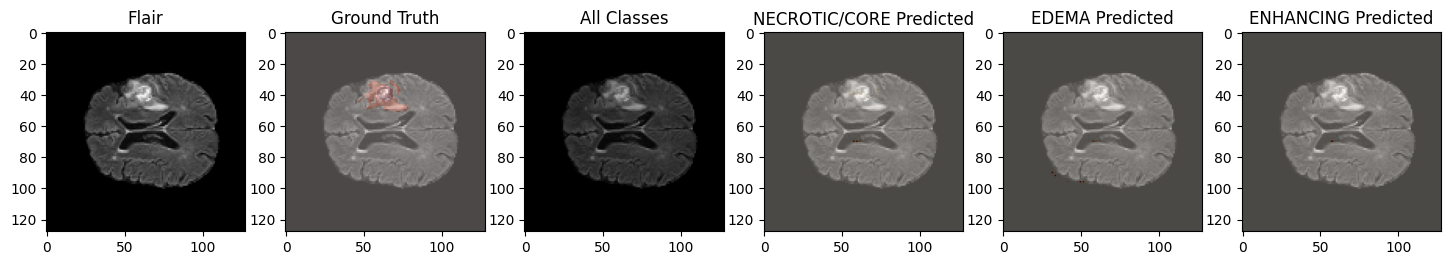

2/2 [==============================] - 0s 84ms/step


<Figure size 1800x5000 with 0 Axes>

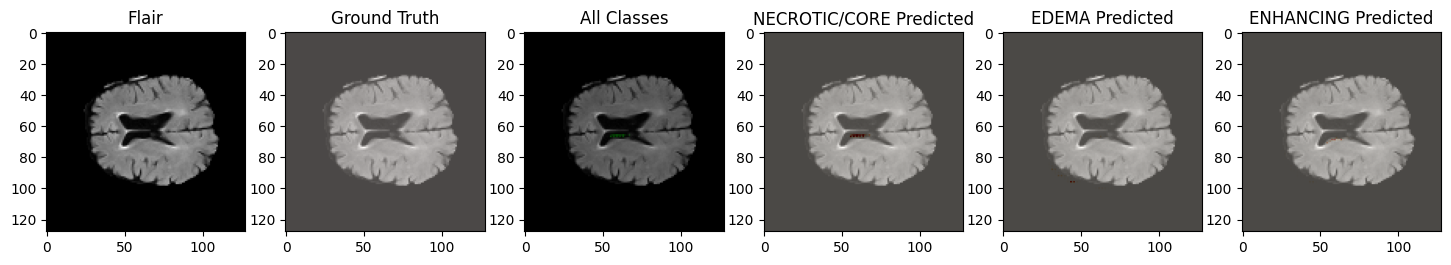

2/2 [==============================] - 0s 79ms/step


<Figure size 1800x5000 with 0 Axes>

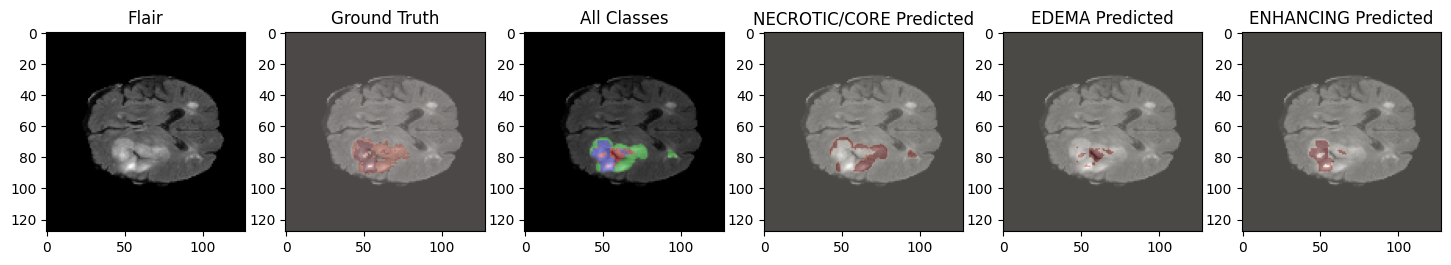

2/2 [==============================] - 0s 79ms/step


<Figure size 1800x5000 with 0 Axes>

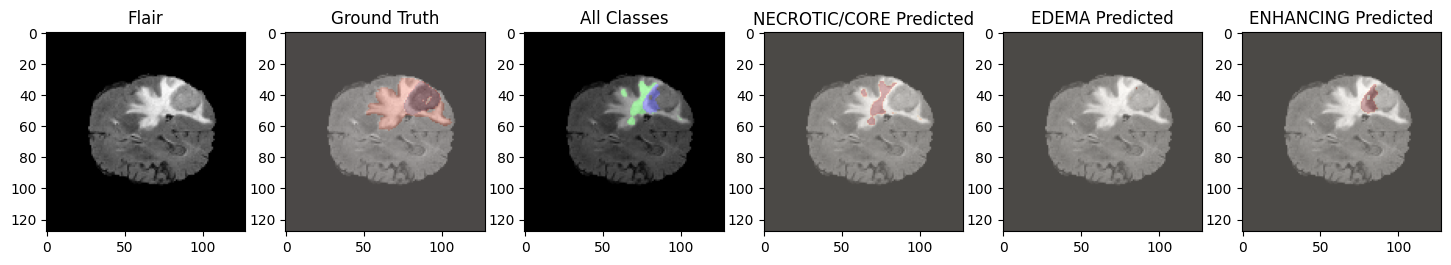

2/2 [==============================] - 0s 78ms/step


<Figure size 1800x5000 with 0 Axes>

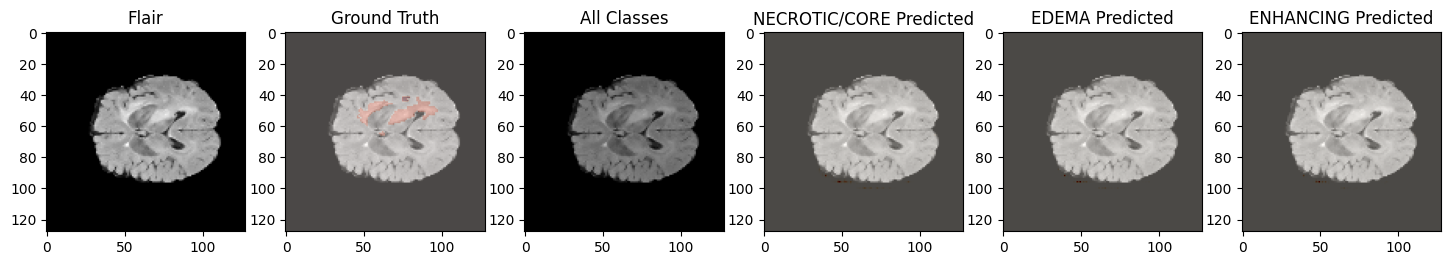

In [ ]:
slice = 25


def view_predicted_data(index):
    data, image, gt = prepare_data_to_predict(TEST_LIST[index])
    p = model.predict(data/np.max(data), verbose=1)
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]
    plt.figure(figsize=(18, 50))
    f, axis_arr = plt.subplots(1, 6, figsize=(18, 50))
    for i in range(6):
        axis_arr[i].imshow(cv2.resize(image[:, :, slice + VOL_START],
                                      (IMG_SIZE, IMG_SIZE)), cmap="gray")

    axis_arr[0].imshow(cv2.resize(image[:, :, slice +
                                        VOL_START], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axis_arr[0].title.set_text('Flair')
    curr_gt = cv2.resize(gt[:, :, slice + VOL_START],
                         (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axis_arr[1].imshow(curr_gt, cmap="Reds", alpha=0.3)
    axis_arr[1].title.set_text('Ground Truth')
    axis_arr[2].imshow(p[slice, :, :, 1:4], cmap="Reds", alpha=0.3)
    axis_arr[2].title.set_text('All Classes')
    axis_arr[3].imshow(edema[slice, :, :], cmap="OrRd", alpha=0.3)
    axis_arr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')
    axis_arr[4].imshow(core[slice, :, ], cmap="OrRd", alpha=0.3)
    axis_arr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')
    axis_arr[5].imshow(enhancing[slice, :, ], cmap="OrRd", alpha=0.3)
    axis_arr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')
    plt.show()


random_index = random.sample(range(len(TEST_LIST)), 5)
for i in random_index:
    view_predicted_data(i)

2/2 [==============================] - 0s 133ms/step


<Figure size 640x480 with 0 Axes>

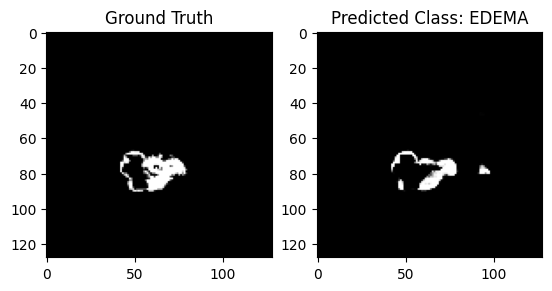

In [ ]:
path = random_index[-3]
base_path = TEST_LIST[path]
data, x, gt = prepare_data_to_predict(base_path)
p = model.predict(data/np.max(data), verbose=1)
core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]
i = 25
eval_class = 2
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:,:,i + VOL_START], (IMG_SIZE, IMG_SIZE))
plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

2/2 [==============================] - 0s 144ms/step


<Figure size 640x480 with 0 Axes>

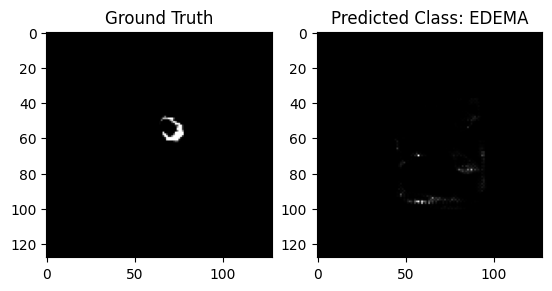

In [ ]:
path = random_index[-3]
base_path = TEST_LIST[path]
data, x, gt = prepare_data_to_predict(base_path)
p = model.predict(data/np.max(data), verbose=1)
core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]
i = 25
eval_class = 2
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:,:,i + VOL_START], (IMG_SIZE, IMG_SIZE))
plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
def show_images(epochs, data, label):
    plt.figure()
    f, axarr = plt.subplots(1,4, figsize=(12,4))
    axarr[0].plot(epochs, data[0], 'y', label=f'Training {label[1]}')
    axarr[0].plot(epochs, data[1], 'r', label=f'Validation {label[1]}')
    axarr[0].set_title(f' {label[1]}')
    axarr[0].set_xlabel(label[0])
    axarr[0].set_ylabel(label[1])
    axarr[0].legend()

    axarr[1].plot(epochs, data[2], 'y', label=f'Training {label[2]}')
    axarr[1].plot(epochs, data[3], 'r', label=f'Validation {label[2]}')
    axarr[1].set_title(f' {label[2]}')
    axarr[1].set_xlabel(label[0])
    axarr[1].set_ylabel(label[2])
    axarr[1].legend()

    axarr[2].plot(epochs, data[4], 'y', label=f'Training {label[3]}')
    axarr[2].plot(epochs, data[5], 'r', label=f'Validation {label[3]}')
    axarr[2].set_title(f' {label[3]}')
    axarr[2].set_xlabel(label[0])
    axarr[2].set_ylabel(label[3])
    axarr[2].legend()

    axarr[3].plot(epochs, data[6], 'y', label=f'Training {label[4]}')
    axarr[3].plot(epochs, data[7], 'r', label=f'Validation {label[4]}')
    axarr[3].set_title(f'{label[4]}')
    axarr[3].set_xlabel(label[0])
    axarr[3].set_ylabel(label[4])
    axarr[3].legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

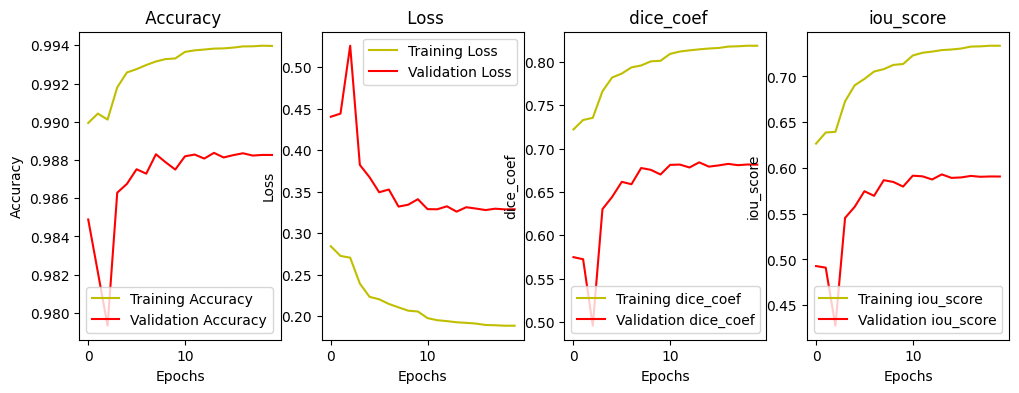

In [ ]:
history = pd.read_csv(LOG[CURRENT_MODEL], sep=',', engine='python')
n = history['epoch']
hist = history
acc=hist['accuracy']
val_acc=hist['val_accuracy']
loss=hist['loss']
val_loss=hist['val_loss']
dice_coef=hist['dice_coef']
val_dice_coef=hist['val_dice_coef']
iou_score=hist['iou_score']
val_iou_score=hist['val_iou_score']
show_images(n, [acc, val_acc, loss, val_loss, dice_coef, val_dice_coef, iou_score, val_iou_score], ['Epochs', 'Accuracy', 'Loss', 'dice_coef', 'iou_score'])